# Minería de Datos: Trabajo Final:

### Importación de las librerías necesarias:

In [1]:
# Importación de bibliotecas estándar
import random
import warnings

# Importación de bibliotecas científicas y de visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de matplotlib para interactividad
plt.ion()  # Mantén la interactividad de matplotlib

# Configuración de la visualización de diagramas de sklearn
from sklearn import set_config
set_config(display="diagram")

# Importación de herramientas de preprocesamiento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
import category_encoders as ce
from sklearn.decomposition import PCA

# Importación de herramientas de selección de características
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile, RFE, RFECV, SequentialFeatureSelector

# Importación de clasificadores
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,
    GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# Importación de herramientas de evaluación y modelado
from sklearn import neighbors, model_selection, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

# Importación de técnicas de remuestreo de imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import (
    EditedNearestNeighbours, RepeatedEditedNearestNeighbours, 
    AllKNN, TomekLinks, RandomUnderSampler, NearMiss
)
from imblearn.combine import SMOTEENN, SMOTETomek

# Importación de herramientas evolutivas de DEAP
from deap import base, creator, tools, algorithms

# Supresión de warnings
warnings.filterwarnings('ignore')

## 1. Carga de datos:

Leemos los datos:

In [2]:
data_path = 'data/data.csv'
data = pd.read_csv(data_path, index_col=0, na_values=["NA", "?", "null", "n/a", "", " "])
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Análisis de datos:

### 2.1. Análisis de los tipos de datos y detección de nulos:

In [3]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [4]:
variables_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

variables_categoricas = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", 
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", 
    "Contract", "PaperlessBilling", "PaymentMethod"
]

Verificamos a ver si hay valores nulos, vacíos o espacios:

In [5]:
# Verificar la cantidad de valores nulos (NaN) en cada columna
conteo_nulos = data.isnull().sum()
print("\nConteo de valores nulos:")
print(conteo_nulos)


Conteo de valores nulos:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


Podemos obsercar que la variable TotalCharges tiene 11 valores nulos.

### 2.2. Distribución de las clases:

Separamos los datos en X e y para facilitar las relaciones de los datos:

In [6]:
variablesEntrada = data.columns[:-1]
variableSalida = data.columns[-1]

X = data.iloc[:, :-1].copy()
y = data.iloc[:,-1].copy()

Convertimos las categorías a números con codificación ordinal:

In [7]:
y[y == "No"] = 0
y[y == "Yes"] = 1
y = y.astype(int)

Analizamos la distribución de las clases de salida:

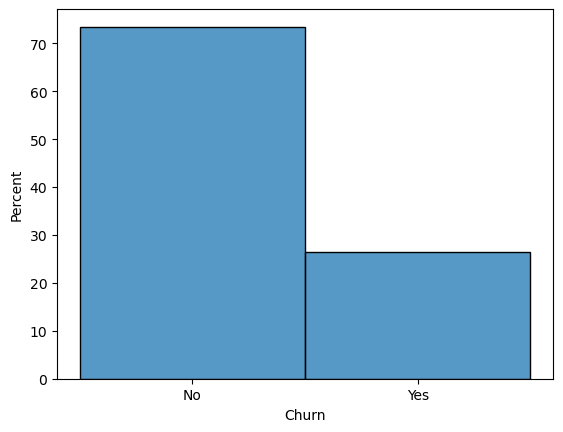

In [8]:
clase_0 = "No"
clase_1 = "Yes"

sns.histplot(data=y, bins=2, stat='percent', discrete=True)
plt.xticks([0, 1], [clase_0, clase_1])
plt.show()

Podemos observar que se trata de un problema de clasificación desbalanceado.

### 2.3. Visualización de las distribuciones de las variables:

Visualizamos la distribución de las variables numéricas:

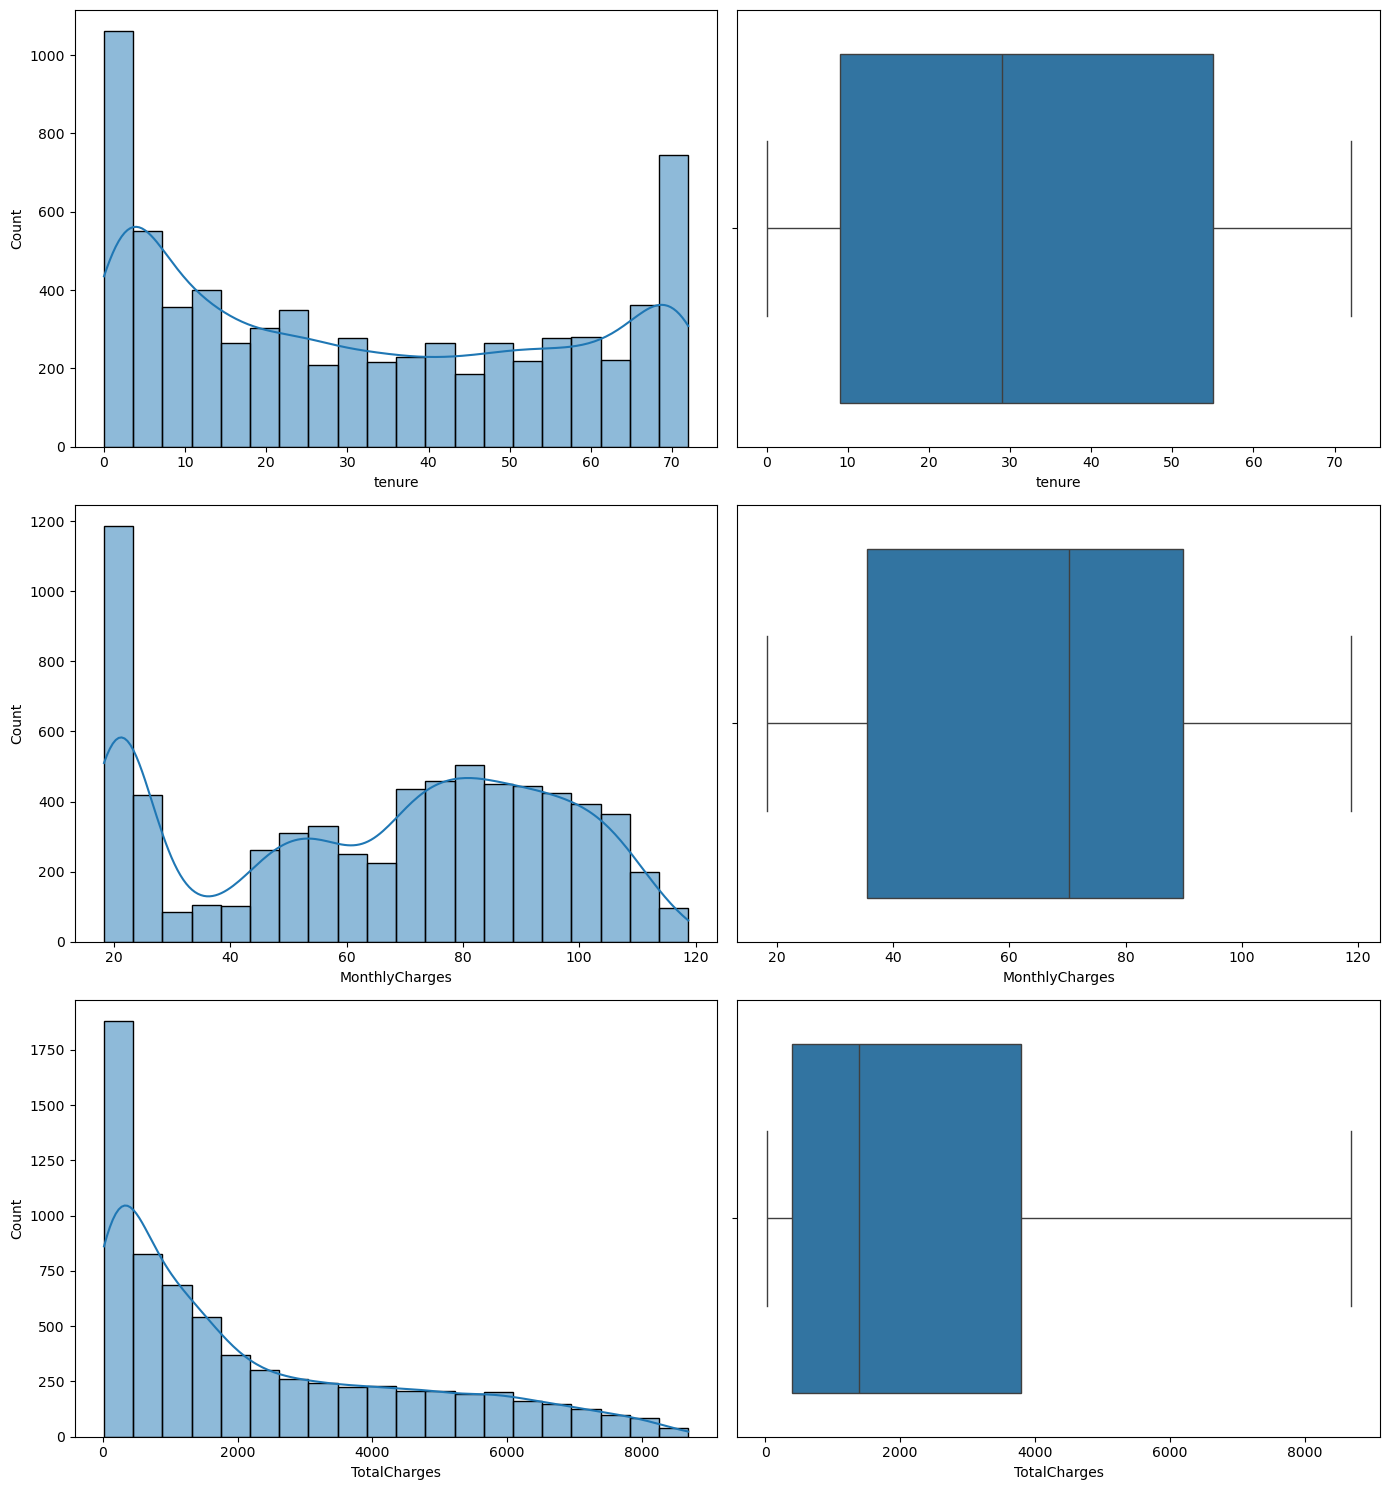

In [9]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=2, figsize=(14, 15))

for i in range(len(variables_numericas)):
    sns.histplot(data=X, x=variables_numericas[i], ax=axes[i, 0], bins=20, kde=True)
    sns.boxplot(data=X, x=variables_numericas[i], ax=axes[i, 1])

fig.tight_layout()

Tenure: Picos en los extremos (muchos clientes nuevos y bastantes viejos). boxplot sin valores atipicos.

Monyhly charges: Un gran número de clientes con cargos bajos y una distribución dispersa en valores más altos. Boxplot con dispersion sin valores extremos.

Total charges: Mayoría valores bajos (En esta podríamos usar lo que hemos dado hoy en clase para cambiar distribución con la raiz o log). Boxplot muestra mucha dispersión y probablemente valores extremos.

Visualizamos la distribución de las variables categóricas:

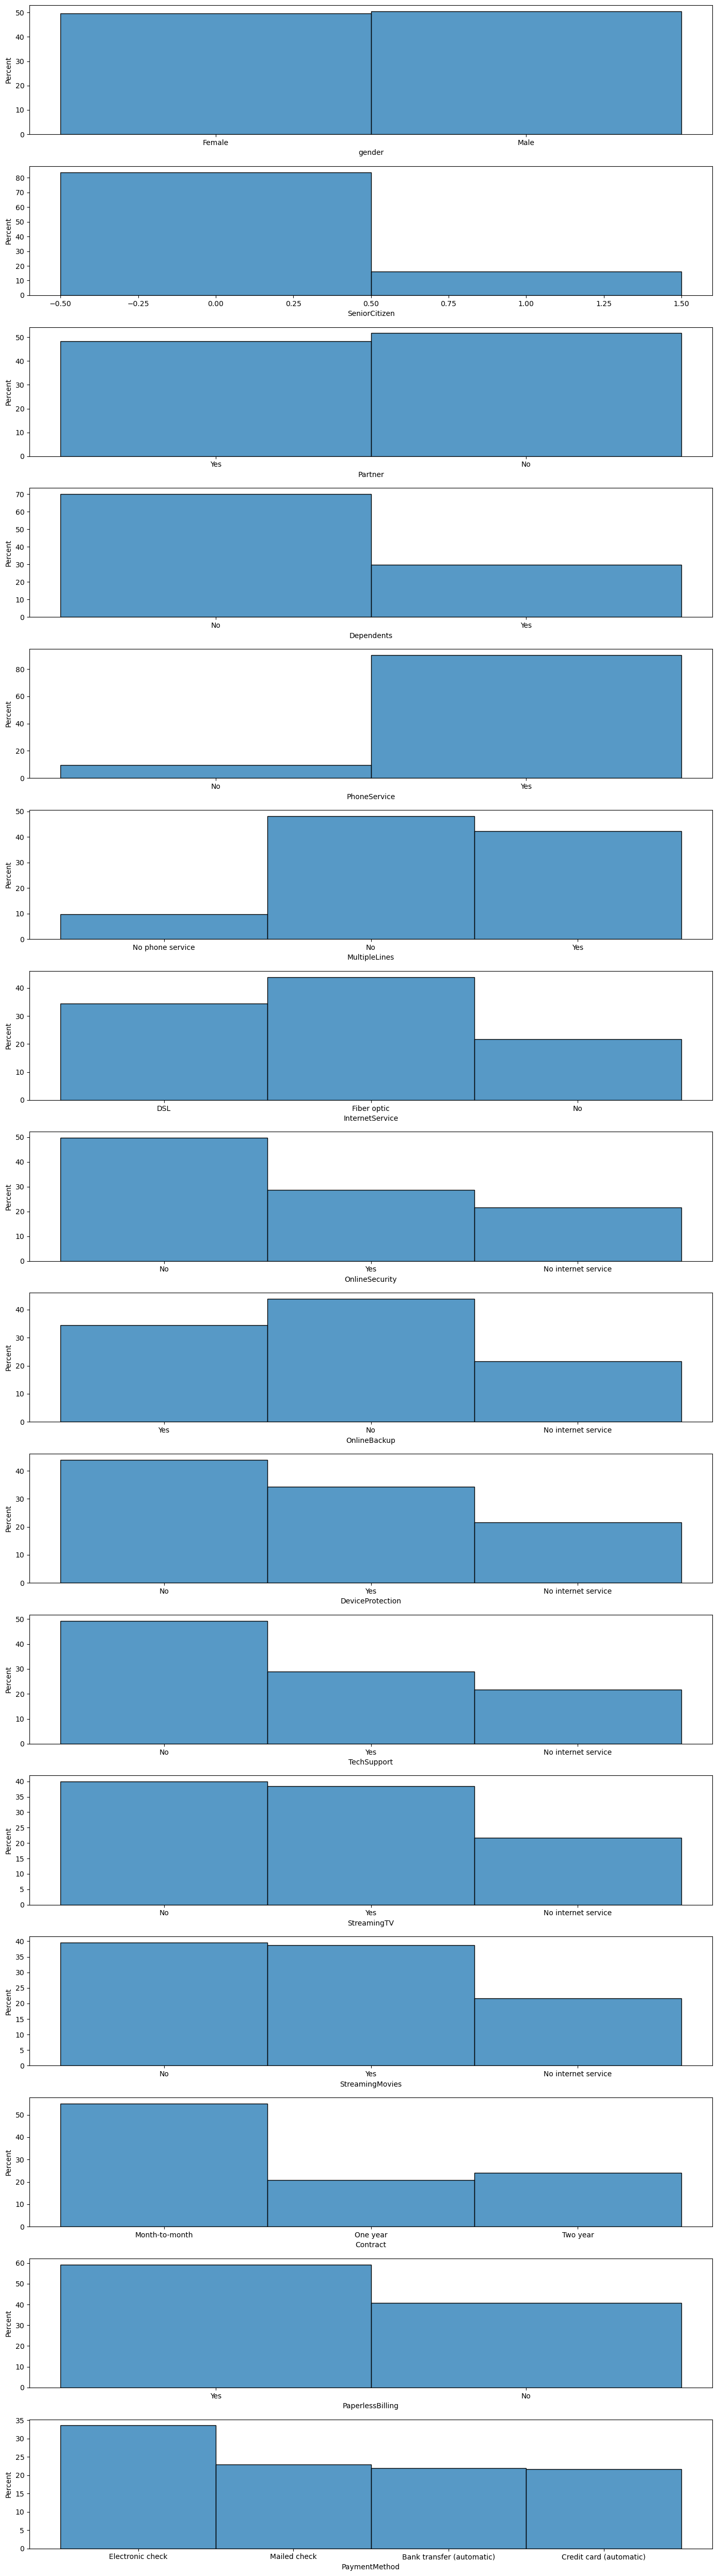

In [10]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 50))

for i in range(len(variables_categoricas)):
    sns.histplot(data=X, x=variables_categoricas[i], stat='percent', discrete=True, ax=axes[i])

fig.tight_layout()

Gender: Equilibrado

Senior citizen: Desequlibrada (mayoria no son senior)

Partner: Equilibrada

Dependemts: Desequilibrada (mayoria no tienen)

Phonr service: Desequlibrada (mayoria tienen)

MultipleLines: Equilibrio entre no y si,pero desequilibrio con sin servicio

InternetService: 

OnlineSecurity/ OnlineBackup/ DeviceProtection/ TechSupport: En todas estas categorías, hay más 
clientes sin estos servicios que con ellos, y un segmento sin servicio de internet.

Streaming TV/ Streaming Movies: Distribución similar: hay más clientes sin estos servicios que con ellos, y algunos sin internet.

Contract: La mayoría de los clientes tienen contrato mensual.

PaperlessBilling:Ligeramente desbalanceada

PaymentMethod: Una clase con mas y tres menores balanceadas

### 2.4. Relación entre las variables de entrada y de salida:

Visualizamos la relación entre las variables numéricas y la salida:

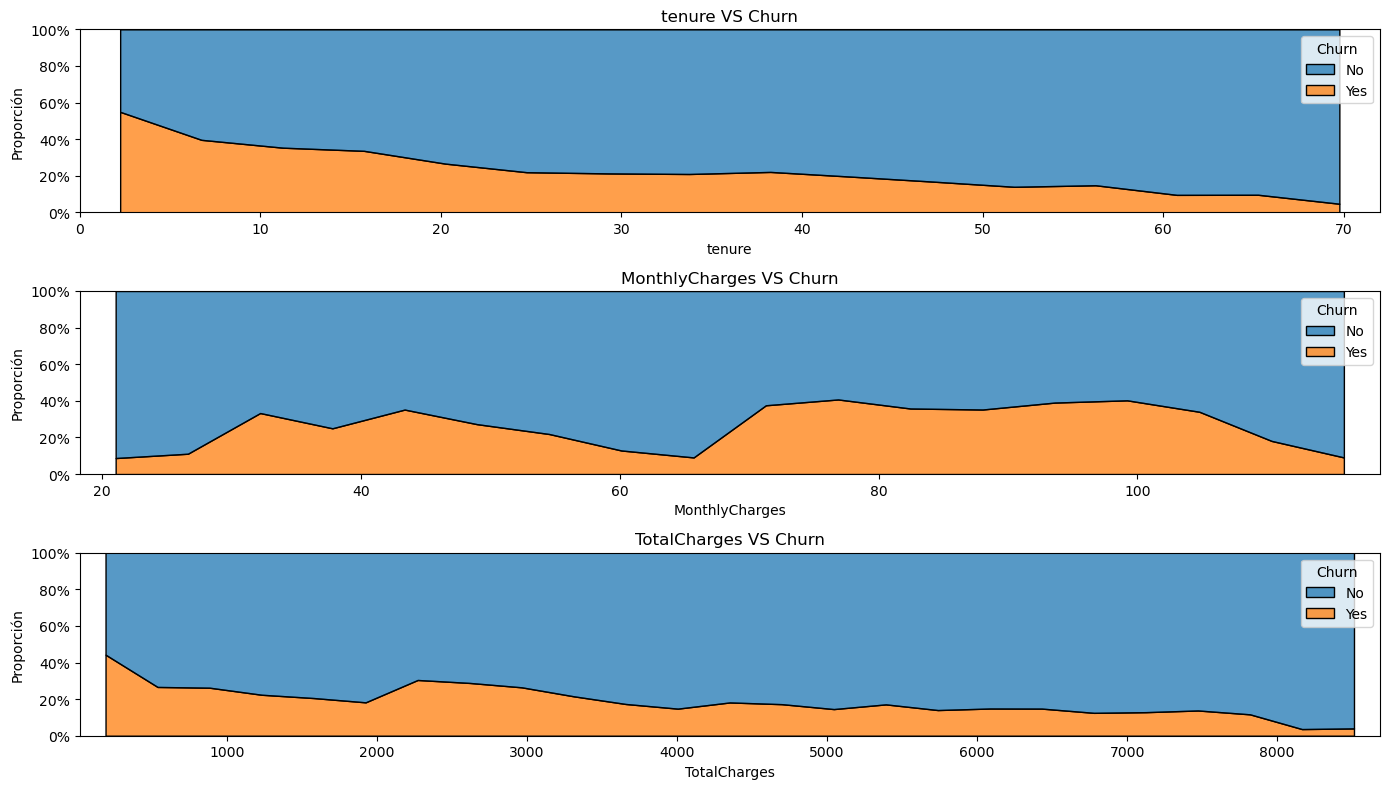

In [11]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=1, figsize=(14, 8))

for i in range(len(variables_numericas)):
    sns.histplot(
        data=data,
        x=variables_numericas[i],
        hue=variableSalida,
        ax=axes[i],
        element='poly',
        stat='probability',
        multiple='fill' 
    )
    axes[i].set_ylabel('Proporción')
    axes[i].set_title(f'{variables_numericas[i]} VS {variableSalida}')
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()


Visualizamos la relación entre las variables categóricas y la salida:

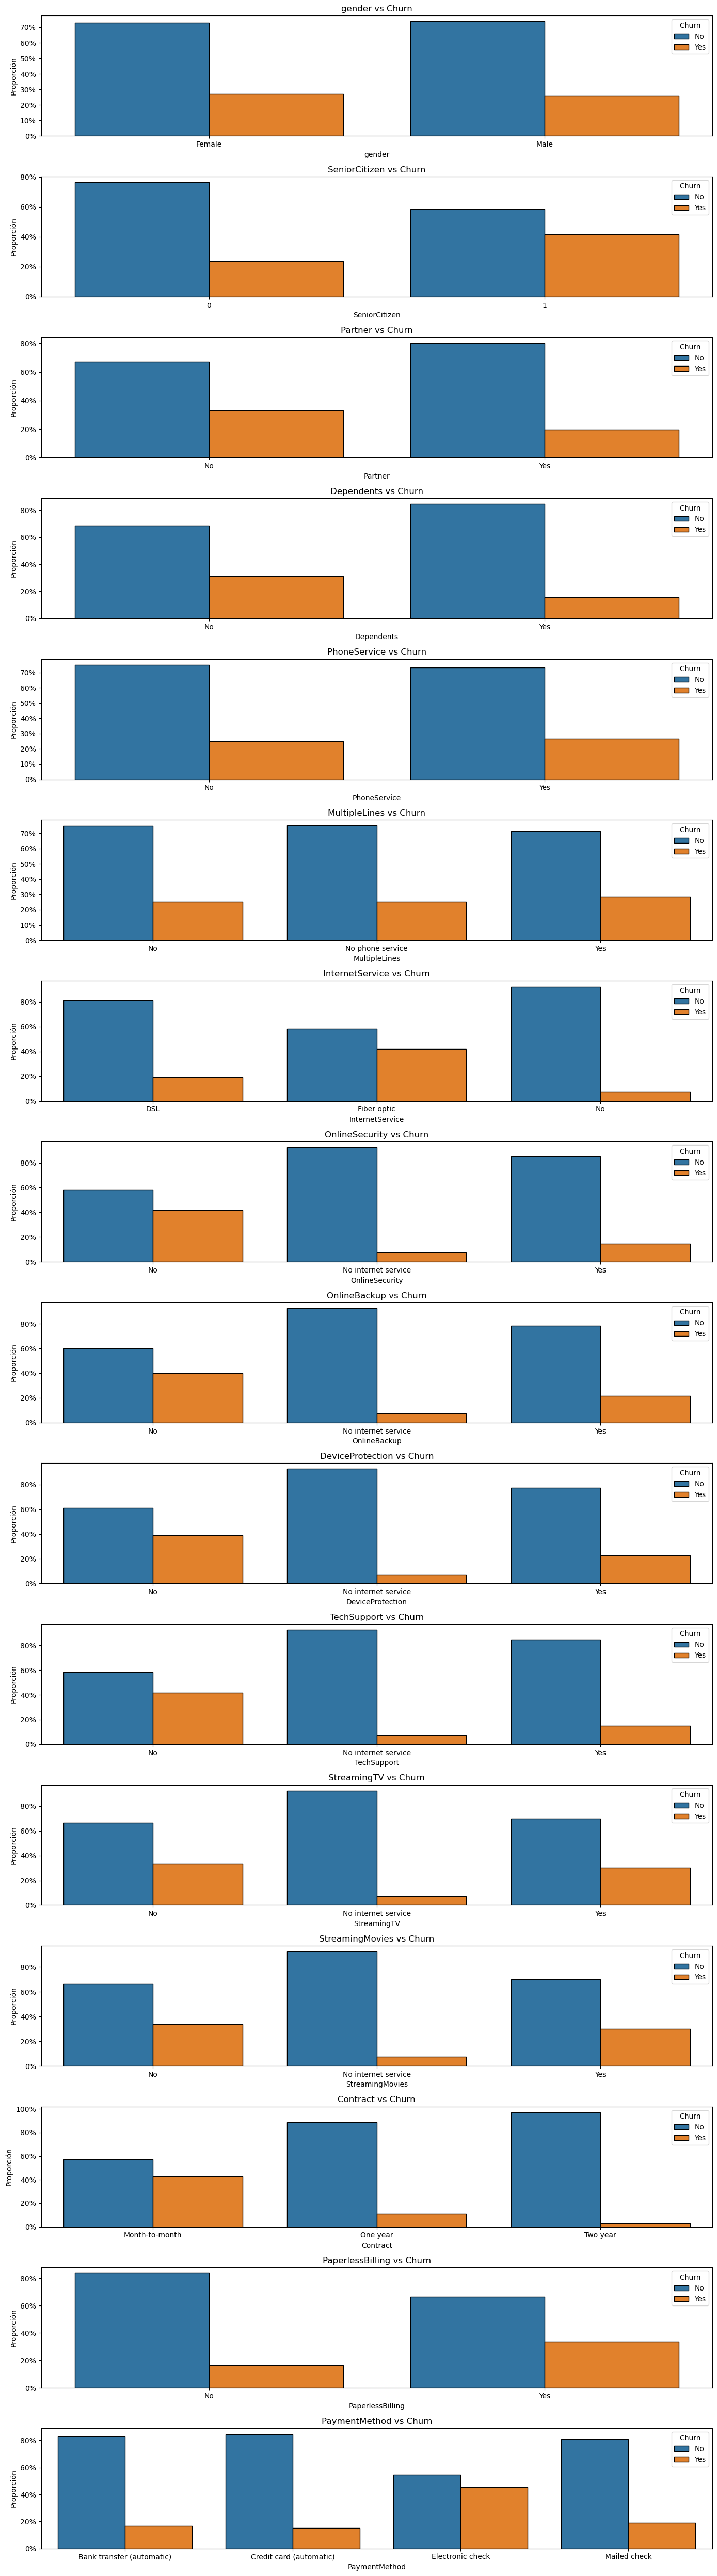

In [12]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 50))

for i, var in enumerate(variables_categoricas):
    # Calculamos la proporción condicional P(clase | categoría)
    prop_df = (
        data.groupby([var, variableSalida])
        .size()
        .reset_index(name='count')
    )

    # Normalizamos dentro de cada categoría
    prop_df['proportion'] = prop_df.groupby(var)['count'].transform(lambda x: x / x.sum())

    sns.barplot(
        data=prop_df,
        x=var,
        y='proportion',
        hue=variableSalida,
        ax=axes[i],
        edgecolor='black', 
        linewidth=1 
    )

    axes[i].set_ylabel('Proporción')
    axes[i].set_title(f'{var} vs {variableSalida}')
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

1. **Género:** No parece haber una diferencia significativa en la tasa de churn entre hombres y mujeres.
2. **Senior Citizen:** Los clientes mayores (senior citizens) tienen una mayor proporción de churn en comparación con los más jóvenes.
3. **Partner (Pareja):** Los clientes sin pareja parecen tener una mayor tasa de churn que aquellos que tienen pareja.
4. **Dependents (Dependientes):** Los clientes sin dependientes tienen una mayor tasa de churn.
5. **Phone Service:** La mayoría de los clientes tienen servicio telefónico, pero no se observa una gran diferencia en churn entre los que lo tienen y los que no.
6. **Multiple Lines:** Los clientes con múltiples líneas parecen tener una tasa de churn mayor en comparación con los que tienen una sola línea o no tienen servicio telefónico.
7. **Internet Service:** La tasa de churn varía según el tipo de servicio de internet, donde los que tienen servicio de fibra óptica parecen tener una tasa de churn más alta en comparación con DSL y los que no tienen internet.
8. **Online Security y Online Backup:** Los clientes que no tienen estos servicios parecen tener una mayor tasa de churn.
9. **Device Protection y Tech Support:** Similar a los anteriores, los clientes sin estos servicios presentan mayor churn.
10. **Streaming TV y Streaming Movies:** No tener estos servicios parece estar asociado con una mayor tasa de churn.
11. **Contract:** Los clientes con contratos mensuales tienen una tasa de churn significativamente más alta en comparación con los que tienen contratos a uno o dos años.
12. **Paperless Billing:** Los clientes con facturación electrónica parecen tener mayor churn en comparación con los que reciben facturas físicas.
13. **Payment Method:** Los clientes que pagan con cheque electrónico tienen la mayor tasa de churn, mientras que los que usan tarjeta de crédito o transferencias bancarias automáticas tienen menor churn.

### Conclusión:
- **Factores que aumentan el churn:** Ser una persona mayor, no tener pareja o dependientes, usar pago con cheque electrónico, tener un contrato mensual, y no contar con servicios adicionales como soporte técnico o seguridad en línea.
- **Factores que reducen el churn:** Tener contratos más largos (uno o dos años), pagar automáticamente con tarjeta o transferencia, y suscribirse a servicios adicionales.


### 2.5. Relación entre variables numéricas:

Visualizamos las relaciones entre las variables numéricas:

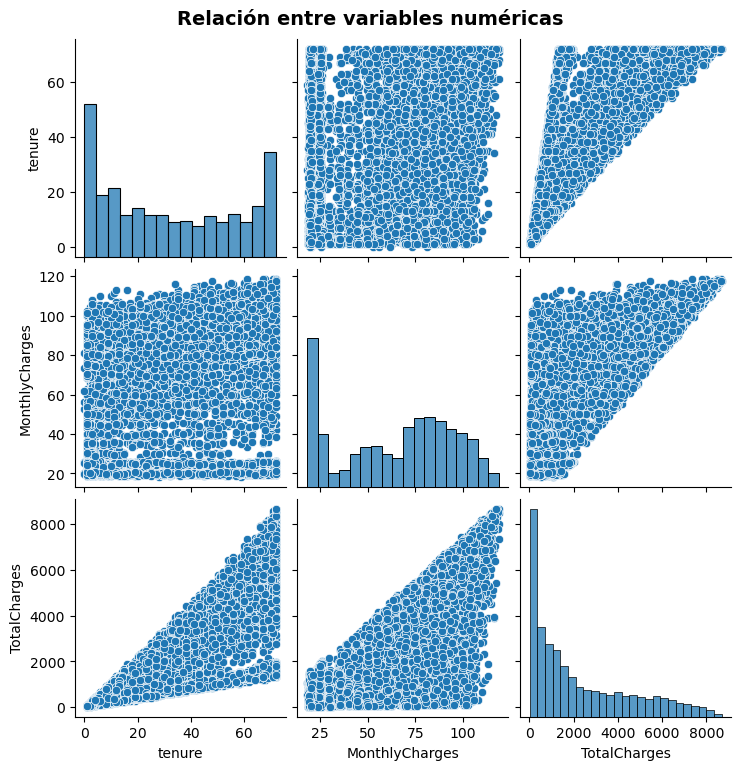

In [13]:
sns.pairplot(data=X[variables_numericas], kind='scatter', diag_kind='hist', height=2.5)
plt.suptitle('Relación entre variables numéricas', y=1.02, fontsize=14, fontweight="bold")
plt.show()

1. **Distribuciones individuales:**
   - **Tenure:** Hay más clientes con poca antigüedad, lo que sugiere que muchas personas cancelan temprano o que hay un flujo constante de nuevos clientes.
   - **MonthlyCharges:** Presenta una distribución uniforme con valores entre aproximadamente 20 y 120.
   - **TotalCharges:** Tiene una distribución sesgada hacia la izquierda, con más clientes con cargos totales bajos (probablemente porque llevan poco tiempo en la empresa).

2. **Relaciones entre variables:**
   - **Tenure vs. MonthlyCharges:** No parece haber una correlación clara entre el tiempo de antigüedad y el monto de los cargos mensuales.
   - **Tenure vs. TotalCharges:** Existe una clara relación lineal positiva, lo cual tiene sentido porque mientras más tiempo un cliente permanezca, mayor será su cargo total.
   - **MonthlyCharges vs. TotalCharges:** También hay una correlación positiva, pero con más dispersión, ya que los cargos totales dependen tanto del monto mensual como de la duración del cliente.

### Conclusión:
- **Los clientes nuevos tienen cargos totales bajos, lo que es esperable.**
- **Los clientes con mayor tiempo tienen cargos totales más altos.**
- **No hay una relación clara entre la antigüedad del cliente y el monto de su cargo mensual.**



## 3. Modelo base

Para comenzar a analizar el efecto de las distintas técnicas de minería de datos en la mejora de las predicciones, es necesario establecer un modelo de referencia sobre el cual aplicar las mejoras posteriores.

El modelo base será lo más sencillo posible, utilizando únicamente el preprocesamiento mínimo necesario para permitir que los algoritmos de aprendizaje automático funcionen correctamente. De esta manera, podremos medir de forma clara el impacto de cada técnica adicional aplicada en fases posteriores.

A continuación analizaremos cual es el preprocesamiento mínimo para que un algoritmo de aprendizaje automático funcione con nuestro conjunto de datos.

### 3.1. Tratamiento de los valores nulos:

Como se ha mencionado anteriormente, hemos encontrado valores nulos en la variable "TotalCharges". Para que nuestro algoritmo de aprendizaje se pueda ejecutar, necesitamos tratar de alguna manera estos valores.

Como primera solución, utilizaremos un imputador por la media de la variable.

### 3.2. Transformación de variables: categórica a numérica:

En nuestro problema tenemos algunas variables categóricas. Estas deben ser convertidas a numéricas, ya que más adelante, cuando necesitemos aplicar un modelo de aprendizaje automático éstas no podrán ser tratadas. Como primera solución, comenzaremos utilizando la codificación binaria por su sencillez.

Las variables categóricas disponibles son las siguientes:

- gender
- SeniorCitizen
- Partner
- Dependents
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod

Sin embargo, no necesitamos codificar todas, ya que SeniorCitizen ya viene codificada en binario.


### 3.3. Modelo de Aprendizaje Automático:

Como modelo base para las pruebas utilizaremos K-Nearest Neighbours con sus valores por defecto.

### 3.4.  Pipelines de preprocesamiento:

Para aplicar el preprocesamiento de manera más sencilla y evitar errores que nos lleven a cometer Data Leakage, crearemos una Pipeline que se encargue de aplicar este preprocesamiento mencionado de manera adecuada.

Primero creamos la Pipeline que preprocesará las variables categóricas aún NO codificadas:

In [14]:
categorical_preprocessor = Pipeline(steps=[
    ('binary_encoder', ce.BinaryEncoder())
])

Crearemos otra Pipeline que se encargue de preprocesar las variables con valores faltantes:

In [15]:
nan_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

Creamos un ColumnTransformer que se encargue de transformar todas las variables:

In [16]:
variables_categoricas = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
            "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
            "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
            "Contract", "PaperlessBilling", "PaymentMethod"]

# Variables con valores faltantes
variables_nan = ["TotalCharges"]

variables_numericas_correctas = ['tenure', 'MonthlyCharges']

# Creamos el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        # Codificamos las variables categóricas
        ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),

        # Imputamos valores en las variables con valores faltantes
        ('nan_preprocessor', nan_preprocessor, variables_nan),
    ],
    # Las demás variables las dejamos igual
    remainder="passthrough"
)

Probamos el preprocesador creado:

In [17]:
X_modified = preprocessor.fit_transform(X)

# Visualizamos los datos transformados
pd.DataFrame(X_modified).head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,29.85,1.0,29.85
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1889.50,34.0,56.95
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,108.15,2.0,53.85
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1840.75,45.0,42.30
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,151.65,2.0,70.70


### 3.5. Creación del modelo:

El modelo base consistirá en el preprocesador creado previamente, combinado con un KNeighborsClassifier, tal y como se ha mencionado anteriormente. Para facilitar estos pasos, se creará una pipeline que ejecute todos los pasos secuencialmente.

In [18]:
modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', neighbors.KNeighborsClassifier())
])

modelo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_preprocessor',
                                                  Pipeline(steps=[('binary_encoder',
                                                                   BinaryEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('nan_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['TotalCharges'])])),
                ('knn', KNeighborsClassifier())])

Definimos una función que entrene el clasificador y devuelva el área bajo la curva (AUC) tanto para el conjunto de entrenamiento como para el de validación, además de la matriz de confusión.

In [19]:
def obtener_resultados(modelo, X_train, y_train, X_val, y_val):
    modelo.fit(X_train, y_train)
    # Calculamos el AUC PR en train
    y_train_prob = modelo.predict_proba(X_train)[:, 1]
    train_auc_pr = metrics.average_precision_score(y_train, y_train_prob) * 100
    # Calculamos el AUC PR en valiación
    y_val_prob = modelo.predict_proba(X_val)[:, 1]
    val_auc_pr = metrics.average_precision_score(y_val, y_val_prob) * 100

    # Calculamos la matriz de confusión en train
    y_train_pred = modelo.predict(X_train)
    cm_train = metrics.confusion_matrix(y_train, y_train_pred)
    # Calculamos la matriz de confusión en valiación
    y_val_pred = modelo.predict(X_val)
    cm_val = metrics.confusion_matrix(y_val, y_val_pred)
    
    return modelo, train_auc_pr, val_auc_pr, cm_train, cm_val

Definimos una función que muestre los resultados calculados con la función anterior:

In [20]:
def mostrar_resultados(train_auc_pr, val_auc_pr, cm_train, cm_val, class_names=None):
    # Imprimir AUC PR
    print(f"AUC-PR (Train): {train_auc_pr:.4f}")
    print(f"AUC-PR (Validación): {val_auc_pr:.4f}")

    # Normalizar matrices por fila (por clase real)
    cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]

    # Configurar los nombres de las clases si no se dan
    if class_names is None:
        class_names = [str(i) for i in range(cm_train.shape[0])]

    # Mostrar mapas de calor con porcentajes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(
        cm_train_norm,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0]
    )
    axes[0].set_title("Matriz de Confusión - Entrenamiento")
    axes[0].set_xlabel("Etiqueta Predicha")
    axes[0].set_ylabel("Etiqueta Real")

    sns.heatmap(
        cm_val_norm,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1]
    )
    axes[1].set_title("Matriz de Confusión - Validación")
    axes[1].set_xlabel("Etiqueta Predicha")
    axes[1].set_ylabel("Etiqueta Real")

    plt.tight_layout()
    plt.show()

A continuación, para probar los componentes creados, dividiremos los datos en entrenamiento, validación y test:

In [21]:
X_resto, X_test, y_resto, y_test = model_selection.train_test_split(X, y, test_size=0.1, stratify=y, random_state=1234)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_resto, y_resto, train_size=0.8, stratify=y_resto, random_state=1234)

## 4. Mejoras en el preprocesamiento:

En este apartado visualizaremos como las distintas técnicas de preprocesamiento pueden mejorar o empeorar el rendimiento del modelo base. 

El objetivo es encontrar las técnicas más apropiadas que hagan maximizar el área bajo la curva precisión-recall.

### 4.1. Imputación de valores faltantes:

En este apartado probaremos cómo afecta cada uno de los métodos de imputación de outliers. Probaremos los siguientes métodos:

- Imputación por la media
- Imputación por la mediana
- Imputación por la moda
- Imputación por KNN

Para realizar las pruebas, crearemos una función para visualizar y comparar los resultados:

In [22]:
def comparar_resultados(resultados, figsize=(10, 6), y_lim=None):
    nombres = np.array([r['nombre_prueba'] for r in resultados])
    train_scores = np.array([r['train_auc_pr'] for r in resultados])
    val_scores = np.array([r['val_auc_pr'] for r in resultados])
    # Ordenamos los valores según los valores obtenidos en validación
    idx_sorted_val_scores = np.argsort(val_scores)[::-1]
    sorted_train_scores = train_scores[idx_sorted_val_scores]
    sorted_val_scores = val_scores[idx_sorted_val_scores]
    sorted_nombres = nombres[idx_sorted_val_scores]

    n = len(nombres)
    if n > 5:
        n = 5

    x = np.arange(n)  # posiciones en el eje X
    width = 0.35  # ancho de las barras

    fig, ax = plt.subplots(figsize=figsize)
    bars1 = ax.bar(x - width/2, sorted_train_scores[:n], width, label='Train AUC-PR')
    bars2 = ax.bar(x + width/2, sorted_val_scores[:n], width, label='Validation AUC-PR')

    ax.set_ylabel('AUC-PR')
    ax.set_title('Comparación de AUC-PR')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_nombres[:n], rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Aplicar límites del eje Y si se proporciona
    if y_lim is not None:
        ax.set_ylim(y_lim)

    # Mostrar los valores encima de las barras
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Probamos los distintos métodos de imputar datos:

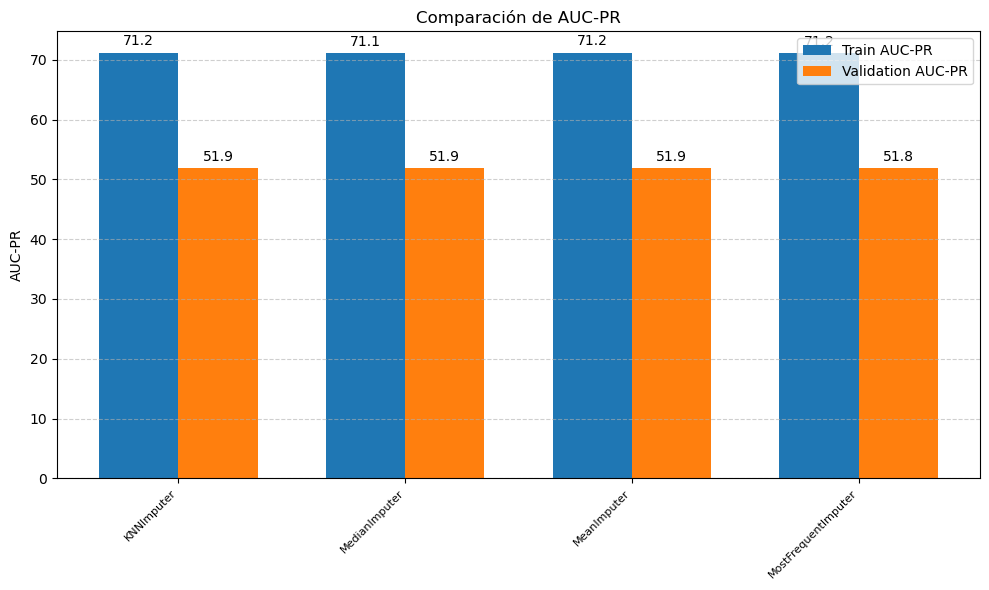

In [23]:
imputers = [("MeanImputer",SimpleImputer(strategy="mean")), 
              ("MedianImputer",SimpleImputer(strategy="median")), 
              ("MostFrequentImputer", SimpleImputer(strategy="most_frequent")),
              ("KNNImputer", KNNImputer())]

resultados = []

for imputer_name, imputer in imputers:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('binary_encoder', ce.BinaryEncoder())
    ])

    # Definimos el preprocesador de variables numéricas con valores faltantes
    nan_preprocessor = Pipeline(steps=[
        ('imputer', imputer)
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('nan_preprocessor', nan_preprocessor, variables_nan)
        ],
        remainder="passthrough"
    )

    # Creamos el modelo
    modelo = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', neighbors.KNeighborsClassifier())
    ])

    # Obtenemos los resultados
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

    # Almacenamos el resultado
    resultado = {"nombre_prueba" : imputer_name,
               "train_auc_pr" : train_auc_pr,
               "val_auc_pr" : val_auc_pr}
    
    resultados.append(resultado)
    
comparar_resultados(resultados)

Ya que no hay gran diferencia, continuaremos con el método de imputación por la media.

### 4.2. Normalización de las variables:

En este apartado visualizaremos el efecto de la normalización sobre las variables numéricas. Probaremos los siguientes métodos de normalización:

- Estandarización mediante la media y la desviación estándar (Z-score)
- Estandarización mediante el mínimo y el máximo (min-max)

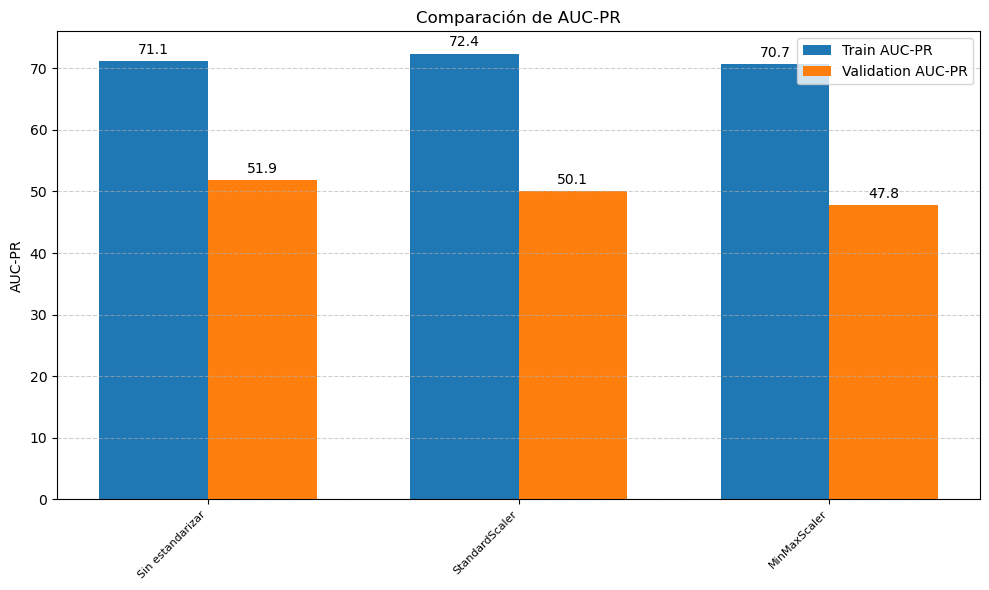

In [24]:
scalers = [("Sin estandarizar", "passthrough"), 
           ("StandardScaler", StandardScaler()), 
           ("MinMaxScaler", MinMaxScaler())]

resultados = []

for scaler_name, scaler in scalers:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('binary_encoder', ce.BinaryEncoder())
    ])

    # Definimos el preprocesador de variables numéricas
    # Preprocesador para variables numéricas con valores faltantes
    nan_preprocessor_steps = [('imputer', SimpleImputer(strategy='median')),
                              ('scaler', scaler)]
    nan_preprocessor = Pipeline(steps=nan_preprocessor_steps)
    # Preprocesador para variables numéricas sin valores faltantes
    numerical_preprocessor = Pipeline(steps=[
        ('scaler', scaler)
    ]) 

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('nan_preprocessor', nan_preprocessor, variables_nan),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_correctas)
        ]
    )

    # Creamos el modelo
    modelo = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', neighbors.KNeighborsClassifier())
    ])

    # Obtenemos los resultados
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

    resultado = {"nombre_prueba" : scaler_name,
               "train_auc_pr" : train_auc_pr,
               "val_auc_pr" : val_auc_pr}
    
    resultados.append(resultado)

comparar_resultados(resultados)

Podemos observar que la opción más conveniente es no normalizar las variables numéricas. Esto probablemente se debe a que una de las variables numéricas tiene una alta relevancia en el modelo. Al aplicar una normalización, se reduce su escala relativa, lo que provoca que su influencia en el cálculo de distancias (especialmente en modelos como KNN) disminuya. En consecuencia, su aporte a la clasificación final se vuelve menos significativo en comparación con dejarla en su escala original.

### 4.3. Detección de outliers:

En este apartado analizaremos el efecto de la detección de outliers. Para ello probaremos los siguientes detectores:

- Detección de outliers mediante el método de la media y la desviación
- Detección de outliers mediante el método del rango intercuartil.



Creamos el componente encargado de detectar outliers mediante el método del rango intercuartil.

In [25]:
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X[self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = X[self.columns] < limiteInf
        mayores = X[self.columns] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            for idx in X[indices].index:
                # Los sustituimos por la mediana
                Xaux.at[idx, c] = self.stats.loc['50%'][c]
                
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Creamos el componente encargado de detectar outliers mediante el método de la media y la desviación.

In [26]:
# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_MeanStd(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=2, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X[self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['mean'] - self.k * self.stats.loc['std']
        limiteSup = self.stats.loc['mean'] + self.k * self.stats.loc['std']
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = X[self.columns] < limiteInf
        mayores = X[self.columns] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            for idx in X[indices].index:
                # Los sustituimos por la mediana
                Xaux.at[idx, c] = self.stats.loc['50%'][c]
                
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Realizamos las pruebas:

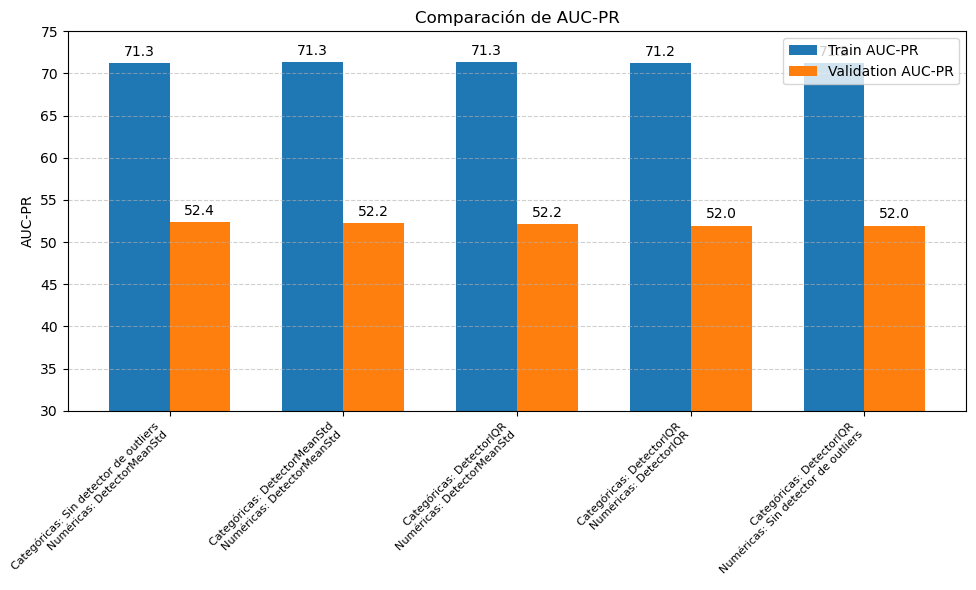

In [27]:
# Lista de detectores para variables categóricas y numéricas
outlier_detectors = [("Sin detector de outliers", "passthrough"),
                     ("DetectorMeanStd", OutlierDetecion_treatment_MeanStd()),
                     ("DetectorIQR", OutlierDetecion_treatment_IQR())]

resultados = []

# Probamos cada combinación de detectores
for detector_cat_name, detector_cat in outlier_detectors:
    for detector_num_name, detector_num in outlier_detectors:
        
        # Preprocesador para variables categóricas
        categorical_preprocessor = Pipeline(steps=[
            ('binary_encoder', ce.BinaryEncoder()),
            ('outlier_detector', detector_cat)
        ])

        # Preprocesador para variables numéricas con valores faltantes
        nan_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('outlier_detector', detector_num)
        ])

        # Preprocesador para variables numéricas sin valores faltantes
        numerical_preprocessor = Pipeline(steps=[
            ('outlier_detector', detector_num)
        ])

        # Creamos el preprocesador final
        preprocessor = ColumnTransformer(
            transformers=[
                ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
                ('nan_preprocessor', nan_preprocessor, variables_nan),
                ('numerical_preprocessor', numerical_preprocessor, variables_numericas_correctas)
            ]
        )

        # Creamos el modelo
        modelo = Pipeline([
            ('preprocessor', preprocessor),
            ('knn', neighbors.KNeighborsClassifier())
        ])

        # Obtenemos los resultados
        _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

        resultados.append({
            "nombre_prueba": "Categóricas: " + detector_cat_name + "\nNuméricas: " + detector_num_name,
            "train_auc_pr": train_auc_pr,
            "val_auc_pr": val_auc_pr
        })

comparar_resultados(resultados, figsize=(10, 6), y_lim=(30, 75))

El modelo que trata los outliers con el detector basado en la media y desviación es el que mayor rendimiento tiene. Por ello, continuaremos con este detector.

### 4.4. Codificación de las variables categóricas:

A continuación analizaremos el efecto de distintos métodos para codificar variables categóricas en variables numéricas. Probaremos los siguientes métodos:

- Codificación por conteo
- Codificación ordinal
- Codificación binaria
- Codificación One Hot Encoding
- Codificación basada en la salida del problema de clasificación

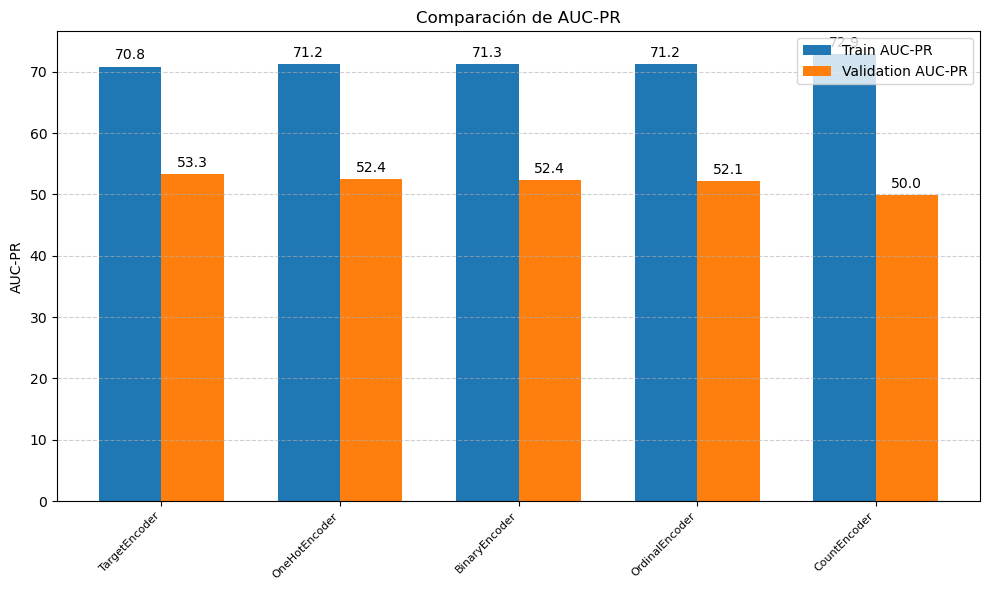

In [28]:
encoders = [("BinaryEncoder", ce.BinaryEncoder()), 
            ("OneHotEncoder", ce.OneHotEncoder()), 
            ("CountEncoder", ce.CountEncoder()), 
            ("OrdinalEncoder", ce.OrdinalEncoder()), 
            ("TargetEncoder", ce.TargetEncoder())]

resultados = []

for encoder_name, encoder in encoders:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', encoder)
    ])

    # Preprocesador para variables numéricas con valores faltantes
    nan_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('outlier_detector', OutlierDetecion_treatment_MeanStd())
    ])

    # Preprocesador para variables numéricas sin valores faltantes
    numerical_preprocessor = Pipeline(steps=[
        ('outlier_detector', OutlierDetecion_treatment_MeanStd())
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('nan_preprocessor', nan_preprocessor, variables_nan),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_correctas)
        ]
    )

    # Creamos el modelo
    modelo = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', neighbors.KNeighborsClassifier())
    ])
    # Obtenemos los resultados
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

    resultado = {"nombre_prueba" : encoder_name,
               "train_auc_pr" : train_auc_pr,
               "val_auc_pr" : val_auc_pr}
    
    resultados.append(resultado)

comparar_resultados(resultados)

Como la codificación basada en la salida es la que mayor rendimiento tiene, continuaremos con él.

### 4.5. Selección de variables:

Cuando se tienen muchos ejemplos de alta dimensionalidad, aplicar técnicas de minería de datos y entrenar modelos de aprendizaje resulta muy costoso. Para reducir el coste computacional, trataremos de identificar las variables más importantes en nuestro problema.

Para ello vamos a utilizar distintas técnicas:

- Filtro de correlación
- Filtro ANOVA
- Sequential Forward Selection (SFS)
- Sequential Backward Elimination (SBE)
- Selección de variables mediante algoritmos genéticos

Con estos métodos, nuestro objetivo es obtener el mayor rendimiento posible con el menor coste computacional posible.

Crearemos una clase encargada de filtrar las variables según su correlación:

In [29]:
class corr_selection(TransformerMixin):

        # Constructor de la clase
        def __init__(self, umbral=0.9, verbose=False):
            # Umbral deseado para determinar variables correlacionadas
            self.umbral = umbral
            # Parámetro que determina si imprimir información del proceso o no
            self.verbose = verbose

        # Método fit
        def fit(self, X, y=None):
            # Transformamos X en DataFrame por si acaso llega en formato ndarray
            X = pd.DataFrame(X)
            # Calculamos la matriz de correlaciones con la función corr de pandas sobre el DataFrame con las variables de entrada X y la ponemos en valor absoluto
            correlaciones = X.corr().abs()
            # Seleccionamos el triángulo superior de la matriz de correlación
            upper = correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype('bool'))
            # Obtenemos los nombres de aquellas variables con correlación mayor al umbral deseado
            self.variables_a_eliminar = list(set([column for i,column in enumerate(upper.columns) if any(upper[column] > self.umbral)]))

             # Si queremos mostrar información se muestra el número de variables eliminadas y sus nombres
            if self.verbose:
                print('Se han eliminado {} variables, que son: {}'.format(len(self.variables_a_eliminar), self.variables_a_eliminar))
            # Devolvemos el objeto modificado (en este caso ha aprendido qué variables se deben eliminar al estar correlacionadas con otras)
            return self

        # Método transform
        def transform(self, X):
            # Transformamos X en DataFrame por si acaso llega en formato ndarray
            X = pd.DataFrame(X)
            # Creamos una copia del DataFrame X para no perder los datos originales
            X_uncorr = X.copy()
            # Eliminamos las variables con alta correlación con algunda de las variables de entrada
            X_uncorr.drop(self.variables_a_eliminar, axis=1, inplace=True)
            # Devolvemos el DataFrame transformado
            return X_uncorr

        # Método para asignar los valores de los híper-parámetros y que, de este modo, 
            # podamos aplicar GridSearchCV sobre un objeto de esta clase
        def set_params(self, **parameters):
            for parameter, value in parameters.items():
                setattr(self, parameter, value)
            return self

        # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
        def get_params(self, deep=True):
            # Devolvemos los valores de los híper-parámetros del método de preparación de datos
            return {"umbral": self.umbral}

Creamos una clase encargada de seleccionar variables con un algoritmo genético:

In [30]:
class SelectorGenetico(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, n_gen=10, population_size=20, scoring=None, cv=3, random_state=42):
        self.estimator = estimator
        self.n_gen = n_gen
        self.population_size = population_size
        self.scoring = scoring
        self.cv = cv
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        n_features = X.shape[1]

        # Definimos el problema de optimización
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Queremos maximizar scoring
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_individual(individual):
            if sum(individual) == 0:
                return 0.0,  # Penalizar no seleccionar ninguna variable
            X_selected = X[:, np.array(individual) == 1]
            scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
            return np.mean(scores),

        toolbox.register("evaluate", eval_individual)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Creamos la población inicial
        population = toolbox.population(n=self.population_size)

        # Evolucionamos
        hof = tools.HallOfFame(1)  # Hall of fame: mejor individuo

        algorithms.eaSimple(population, toolbox,
                            cxpb=0.5, mutpb=0.2,
                            ngen=self.n_gen,
                            halloffame=hof,
                            verbose=False)

        # Guardamos las mejores features
        self.best_features_ = np.array(hof[0], dtype=bool)

        return self

    def transform(self, X):
        return X[:, self.best_features_]

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)



Para poder evaluar el rendimiento de nuestro modelo en los métodos de selección de variables, primero crearemos un scorer para la métrica del área bajo la curva Precisión - Recall:

In [31]:
score_PR = metrics.make_scorer(score_func=metrics.average_precision_score,
                               greater_is_better=True, 
                               response_method=['predict_proba', 'decision_function', 'predict'])

Definiremos el preprocesador que vamos a utilizar, con los pasos elegidos en los apartados anteriores:

In [32]:
categorical_preprocessor = Pipeline(steps=[
    ('encoder', ce.TargetEncoder())
])
# Definimos el preprocesador de variables numéricas
# Preprocesador para variables numéricas con valores faltantes
nan_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier_detector', OutlierDetecion_treatment_MeanStd())
])

# Preprocesador para variables numéricas sin valores faltantes
numerical_preprocessor = Pipeline(steps=[
    ('outlier_detector', OutlierDetecion_treatment_MeanStd())
])

# Creamos el preprocesador final
preprocessor = ColumnTransformer(
    transformers=[
        # Codificamos las variables categóricas
        ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),

        # Imputamos valores en las variables con valores faltantes
        ('nan_preprocessor', nan_preprocessor, variables_nan),

        ('numerical_preprocessor', numerical_preprocessor, variables_numericas_correctas)
    ]
)

Creamos una lista con los métodos de selección que vamos a probar:

In [33]:
# Definimos el estimador base para los métodos secuenciales
clf_base = KNeighborsClassifier()

# Lista de métodos de selección de variables con nombre e instancia
metodos_seleccion = []

# Método sin selección
metodos_seleccion.append(('SinSeleccion', None))

umbrales_correlacion = [0.7, 0.8, 0.9]
for umbral in umbrales_correlacion:
    metodos_seleccion.append((
        f'Correlacion_{umbral}', 
        corr_selection(umbral=umbral)
    ))

# Métodos secuenciales
numeros_caracteristicas = [3, 5, 10, 15]

for num_feats in numeros_caracteristicas:
    # SelectKBest con diferentes valores de k
    metodos_seleccion.append((
        f'SelectKBest_{num_feats}', 
        SelectKBest(score_func=f_classif, k=num_feats)
    ))

    # SFS Forward
    metodos_seleccion.append((
        f'SFS_Forward_{num_feats}', 
        SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=num_feats,
            direction='forward',
            scoring=score_PR,
            cv=5,
            n_jobs=-1
        )
    ))

    # SFS Backward
    metodos_seleccion.append((
        f'SFS_Backward_{num_feats}', 
        SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=num_feats,
            direction='backward',
            scoring=score_PR,
            cv=5,
            n_jobs=-1
        )
    ))

# Agregamos el selector genético
metodos_seleccion.append((
    'GeneticSelector', 
    SelectorGenetico(
        estimator=clf_base,         
        scoring=score_PR, 
        n_gen=200,               
        population_size=30,    
        cv=model_selection.StratifiedShuffleSplit(n_splits=1, 
                                                   test_size=0.2, 
                                                   random_state=0),                      
        random_state=0
    )
))

Realizamos la prueba:

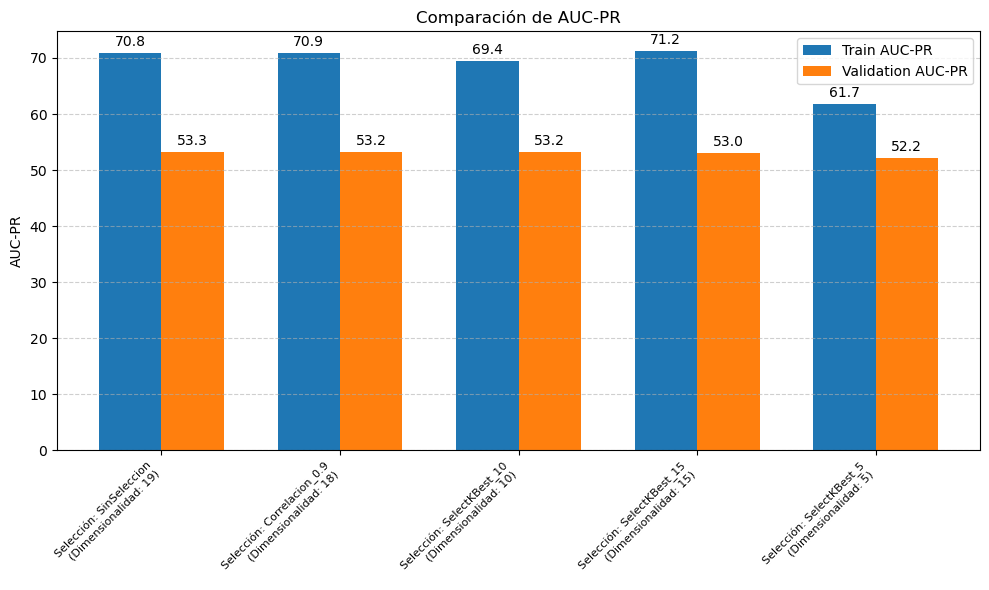

In [34]:
resultados = []

for selector_name, selector in metodos_seleccion:
    # Construímos la pipeline
    steps = [('preprocessor', preprocessor)]
    
    # Añadimos el paso de seleccionar variables si es necesario
    if selector is not None:
        steps.append(('selector', selector))
    
    # Añadimos el clasificador base
    steps.append(('clf', clf_base))
    
    # Creamos el modelo
    modelo = Pipeline(steps)

    # Evaluación
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

    # Cálculo del número de características seleccionadas
    if selector is None:
        num_feats = X_train.shape[1]  # Sin selección, todas las características
    elif isinstance(selector, SelectKBest) or isinstance(selector, SelectPercentile):
        # Si es un filtro como SelectKBest o SelectPercentile
        num_feats = np.sum(selector.get_support())  # Número de características seleccionadas
    elif isinstance(selector, SequentialFeatureSelector):
        # Si es un selector secuencial
        num_feats = selector.n_features_to_select  # Número de características seleccionadas
    elif hasattr(selector, 'variables_a_eliminar'):
        # Si el selector tiene el atributo 'variables_a_eliminar', calculamos el número de características
        num_feats = X_train.shape[1] - len(selector.variables_a_eliminar)
    else:
        num_feats = "N/A"  # En caso de que no se pueda determinar el número de características

    # Guardar resultados (estructura simplificada)
    resultados.append({
        "nombre_prueba": f"Selección: {selector_name}\n(Dimensionalidad: {num_feats})",
        "train_auc_pr": train_auc_pr,
        "val_auc_pr": val_auc_pr
    })

comparar_resultados(resultados)

Podemos observar que el rendimiento no mejora con menos variables, de hecho, el rendimiento empeora un poco. Sin embargo, si seleccionamos las variables mediante el filtro ANOVA, podemos tener un modelo que funciona casi igual de bien con la mitad de variables. Más exactamente, podemos pasar de 19 variables a 10.

Por ello, continuaremos utilizando esta selección de variables.

### 4.6. Transformación de variables:

Otra técnica utilizada para reducir la dimensionalidad es el Análisis de Componentes Principales (PCA). Esta técnica estadística es utilizada para aumentar la separabilidad de los datos. 

Para probar que tal se adapta esta técnica a nuestro problema, crearemos una nueva pipeline con el siguiente flujo:

- Preprocesamiento de los datos
- Selección de variables
- Normalización de los datos, para que la media sea 0 y la desviación estándar 1 (necesario para aplicar PCA)
- Aplicamos la transformación PCA
- Entrenamiento del clasificador base

In [35]:
metodos_transformacion = [("Sin transformación", None),
                          ("PCA_95", PCA(0.95))]

resultados = []

for nombre_transformador, transformador in metodos_transformacion:
    # Construimos los steps básicos
    steps = [('preprocessor', preprocessor),
             ('selector', SelectKBest(score_func=f_classif, k=10))]
    
    # Añadimos transformación si corresponde
    if transformador is not None:
        steps.extend([
            ('scaler', StandardScaler()),
            ('transformador', transformador)
        ])
    
    # Añadimos el clasificador
    steps.append(('clf', clf_base))
    
    # Creamos el pipeline
    modelo = Pipeline(steps)

    # Entrenamos el modelo para calcular resultados
    modelo, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)

    if transformador is not None:
        n_dimensiones = modelo.named_steps['transformador'].n_components_
    else:
        # Sin transformación adicional
        n_dimensiones = 10

    nombre_prueba_final = f"{nombre_transformador} (Dimensionalidad: {n_dimensiones})"
    
    # Guardamos resultados
    resultados.append({
        "nombre_prueba": nombre_prueba_final,
        "train_auc_pr": train_auc_pr,
        "val_auc_pr": val_auc_pr
    })

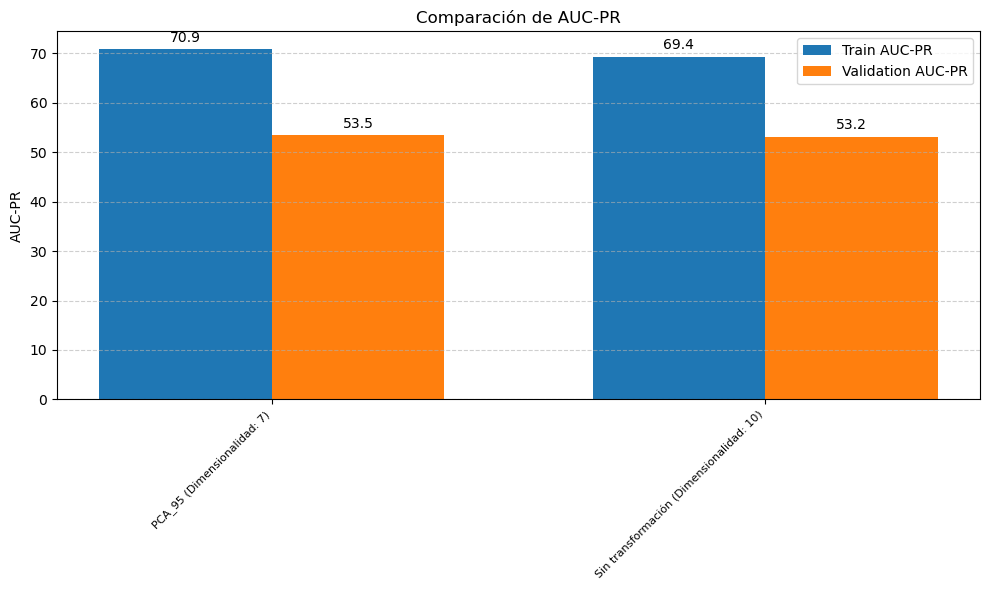

In [36]:
comparar_resultados(resultados)

Al comparar el modelo que utiliza PCA con el que no lo emplea, observamos un aumento de 0.3 en el AUC-PR. Aunque esta mejora pueda parecer modesta, es importante destacar que, además de mejorar el rendimiento, hemos logrado reducir nuevamente la dimensionalidad, pasando de 10 variables a 7.

Por tanto, continuaremos utilizando PCA.

### 4.7. Eliminación del ruido

El ruido representa un desafío importante en los problemas de clasificación, ya que puede confundir al modelo durante el proceso de aprendizaje y dificultar la correcta predicción de ejemplos pertenecientes a distintas clases.

Para mitigar este problema, se evaluará el efecto de diferentes técnicas de eliminación de ruido, concretamente:

- **Edited Nearest Neighbours (ENN)**
- **Repeated Edited Nearest Neighbours (RENN)**
- **All KNN**
- **Tomek Links**

Estas técnicas buscan limpiar el conjunto de datos eliminando o corrigiendo instancias conflictivas, con el objetivo de mejorar el rendimiento y la generalización de los modelos de clasificación.


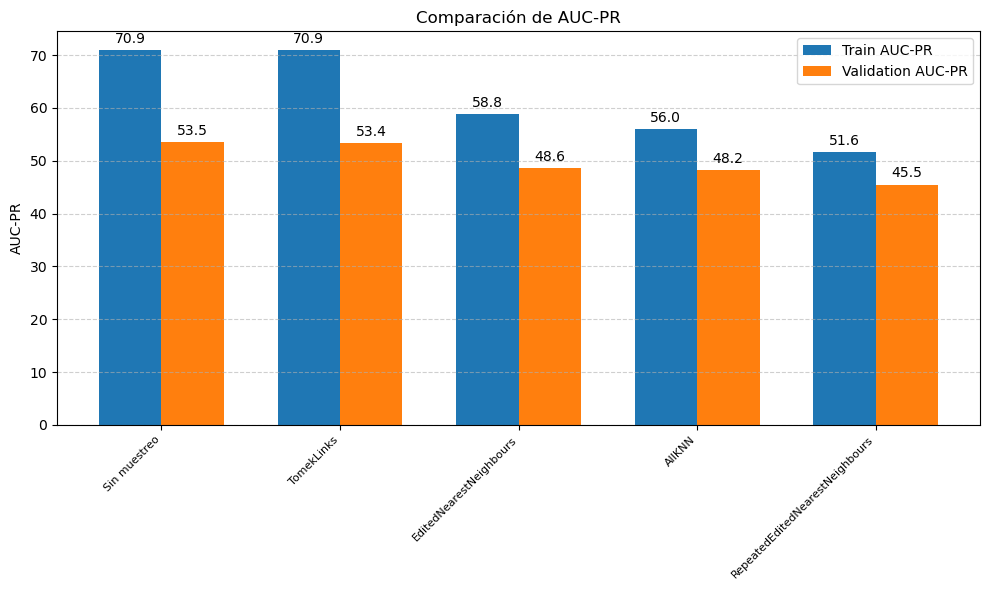

In [37]:
tecnicas_eliminacion_ruido = [
    None,
    EditedNearestNeighbours(),
    RepeatedEditedNearestNeighbours(),
    AllKNN(),
    TomekLinks()]

resultados = []
for tecnica in tecnicas_eliminacion_ruido:
    # Definimos los pasos de la pipeline
    steps = [('preprocessor', preprocessor), 
            ('selector', SelectKBest(score_func=f_classif, k=10)),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95))]
    
    if tecnica is not None:
        nombre_tecnica = tecnica.__class__.__name__
        steps.append(('muestreo', tecnica))
    else:
        nombre_tecnica = "Sin muestreo"
        
    steps.append(('clf', clf_base))
    
    modelo = Pipeline(steps)

    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)
    
    resultados.append({"nombre_prueba" : nombre_tecnica,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

Dado que la eliminación de ruido no ha demostrado mejorar el rendimiento, se ha decidido no utilizar estas técnicas en el flujo de trabajo. 

La falta de mejora podría estar relacionada con la propia naturaleza del conjunto de datos. Por ejemplo, en datasets donde las clases están altamente entremezcladas y no existe una separación clara entre ellas, resulta muy difícil identificar y eliminar instancias ruidosas de manera efectiva.


### 4.8. Desbalanceo del problema:

Uno de los mayores problemas presentes en nuestro dataset es el desbalanceo presente en este. Para tratar de balancearlo, aplicaremos distintas técnicas de muestreo e hibridaciones:

Muestreo:

- Random Under Sampling
- Random Over Sampling
- SMOTE

Hibridaciones:

- SMOTE + ENN
- SMOTE + Tomek

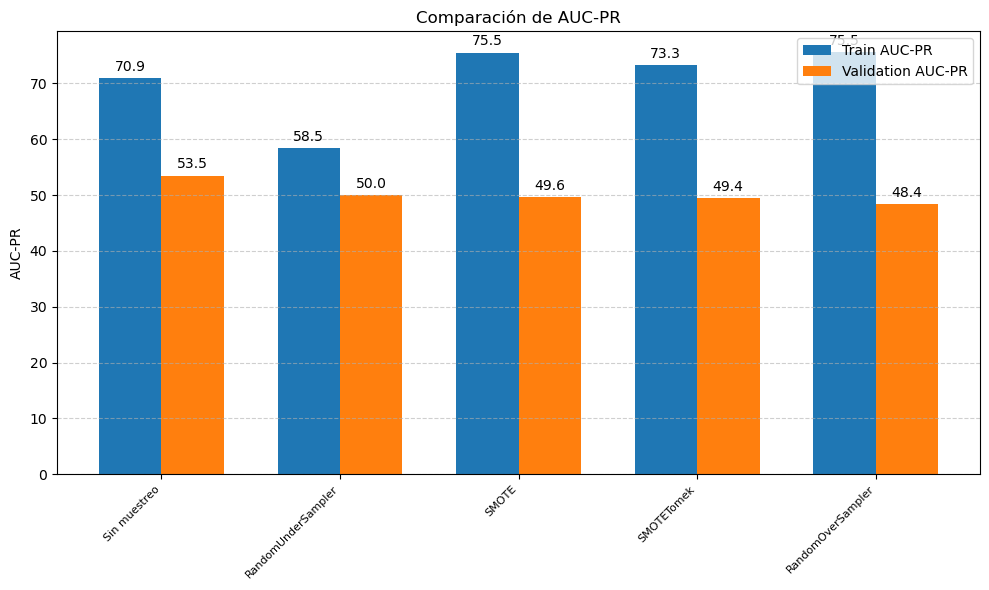

In [38]:
# Lista de técnicas de muestreo
muestreos = [
    None,
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    RandomUnderSampler(random_state=0),
    SMOTEENN(random_state=0),
    SMOTETomek(random_state=0)
]

resultados = []
for muestreo in muestreos:
    # Definimos los pasos de la pipeline
    steps = [('preprocessor', preprocessor), 
            ('selector', SelectKBest(score_func=f_classif, k=10)),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95))]
    
    if muestreo is not None:
        nombre_tecnica = muestreo.__class__.__name__
        steps.append(('muestreo', muestreo))
    else:
        nombre_tecnica = "Sin muestreo"

    steps.append(("clf", clf_base))
    
    modelo = Pipeline(steps)

    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)
    
    resultados.append({"nombre_prueba" : nombre_tecnica,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

Por la misma razón que motivó la falta de mejora al aplicar técnicas de eliminación de ruido, el balanceo del dataset tampoco ha producido una mejora en el rendimiento. 

Por tanto, no se aplicará ninguna técnica de remuestreo ni métodos híbridos en el flujo de trabajo.


## 5. Elección del modelo:

En este apartado probaremos distintos modelos de aprendizaje automático, para ver cuál se adapta mejor a nuestro problema de clasificación. Luego maximizaremos su rendimiento aplicando técnicas de búsqueda de los mejores hiper-parámetros.

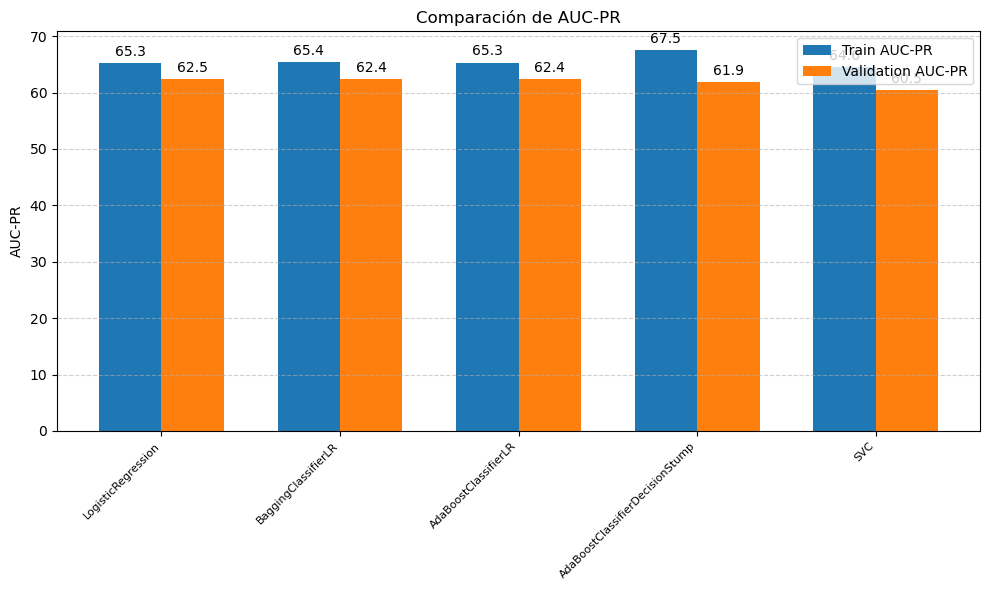

In [39]:
clasificadores = [
    ("KNN", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier(random_state=0)),
    ("LogisticRegression", LogisticRegression()),
    ("SVC", SVC(probability=True, random_state=0)),
    ("RandomForestClassifier", RandomForestClassifier(random_state=0)),
    ("AdaBoostClassifierDecisionStump", AdaBoostClassifier(random_state=0)),
    ("AdaBoostClassifierLR", AdaBoostClassifier(estimator=LogisticRegression(), random_state=0)),
    ("AdaBoostClassifierDT", AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=0), random_state=0)),
    ("AdaBoostClassifierRF", AdaBoostClassifier(estimator=RandomForestClassifier(), random_state=0)),
    ("BaggingClassifierLR", BaggingClassifier(estimator=LogisticRegression(), random_state=0)),
    ("XGBClassifier", XGBClassifier())
]

resultados = []
for clasificador_nombre, clasificador in clasificadores:
    # Definimos los pasos de la pipeline
    steps = [('preprocessor', preprocessor), 
            ('selector', SelectKBest(score_func=f_classif, k=10)),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('clf', clasificador)]
    
    modelo = Pipeline(steps)

    modelo, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val, y_val)
    
    resultados.append({"nombre_prueba" : clasificador_nombre,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

## 6. Interpretabilidad del modelo: